<a href="https://colab.research.google.com/github/pranathadoddy/down-syndrome/blob/main/Resnet87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets

from torchvision import datasets
from torchvision import transforms

from torchvision import models

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from PIL import Image

## Download DataSet

In [2]:
!pip install kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir ~/.kaggle

In [5]:
! cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download mervecayli/detection-of-down-syndrome-in-children

 95% 29.0M/30.5M [00:01<00:00, 20.3MB/s]
100% 30.5M/30.5M [00:01<00:00, 19.6MB/s]


In [8]:
! unzip detection-of-down-syndrome-in-children.zip

Archive:  detection-of-down-syndrome-in-children.zip
  inflating: downSyndorme/downSyndrome/down_1.jpg  
  inflating: downSyndorme/downSyndrome/down_10.jpg  
  inflating: downSyndorme/downSyndrome/down_100.jpg  
  inflating: downSyndorme/downSyndrome/down_1000.jpg  
  inflating: downSyndorme/downSyndrome/down_1001.jpg  
  inflating: downSyndorme/downSyndrome/down_1002.jpg  
  inflating: downSyndorme/downSyndrome/down_1003.jpg  
  inflating: downSyndorme/downSyndrome/down_1004.jpg  
  inflating: downSyndorme/downSyndrome/down_1005.jpg  
  inflating: downSyndorme/downSyndrome/down_1006.jpg  
  inflating: downSyndorme/downSyndrome/down_1007.jpg  
  inflating: downSyndorme/downSyndrome/down_1008.jpg  
  inflating: downSyndorme/downSyndrome/down_1009.jpg  
  inflating: downSyndorme/downSyndrome/down_101.jpg  
  inflating: downSyndorme/downSyndrome/down_1010.jpg  
  inflating: downSyndorme/downSyndrome/down_1011.jpg  
  inflating: downSyndorme/downSyndrome/down_1012.jpg  
  inflating: downSy

# Clean Datasets

In [9]:
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 100

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [10]:
down_syndrome_folder = "/content/downSyndorme/downSyndrome"
healthy_folder = "/content/healty/healty"

# Function to extract filenames and assign class
def create_df_from_folder(folder, class_value):
    files = os.listdir(folder)
    df = pd.DataFrame({'dosya': files, 'class': class_value})
    return df

# Create DataFrames for each folder
down_syndrome_df = create_df_from_folder(down_syndrome_folder, 1)
healthy_df = create_df_from_folder(healthy_folder, 0)

# Concatenate the DataFrames
df = pd.concat([down_syndrome_df, healthy_df], ignore_index=True)

df.set_index('dosya', inplace=True)
df


,class
dosya,
down_721.jpg,1
down_625.jpg,1
down_622.jpg,1
down_851.jpg,1
down_915.jpg,1
...,...
healty_911.jpg,0
healty_962.jpg,0
healty_570.jpg,0


In [11]:
class_counts = df.groupby('class').size()

class_counts

class
0    1499
1    1500
dtype: int64

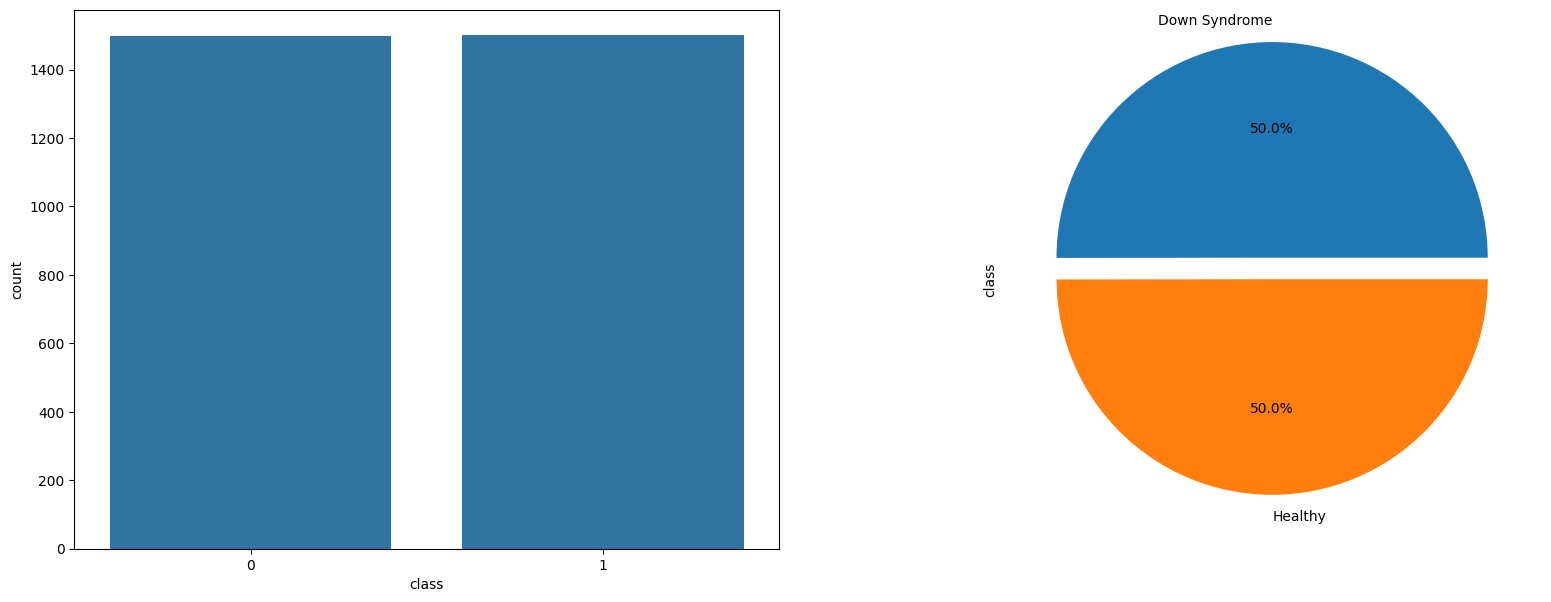

In [12]:
fig, ax = plt.subplots(1,2, figsize=(20,7))

sns.countplot(x=df["class"], ax=ax[0])
df["class"].value_counts().plot.pie(explode=[0.1, 0],autopct="%1.1f%%",labels=["Down Syndrome", "Healthy"], ax=ax[1])

plt.show()

## Train Test Split

In [13]:
train, test_df = train_test_split(df, test_size = 0.3, random_state=1, shuffle=True)
validate, test = train_test_split(test_df, test_size=0.33, random_state=1, shuffle=True)

In [14]:
train.shape, validate.shape, test.shape

((2099, 1), (603, 1), (297, 1))

In [15]:
train.to_csv('downsyndrome_train.csv')
validate.to_csv('downsyndrome_valid.csv')
test.to_csv('downsyndrome_test.csv')

## Data Loader

In [22]:
class ImageDownSyndromeDataset(Dataset):

    def __init__(self, csv_path, img_dir, transform=None):

        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['class'].values
        self.transform = transform

    def __getitem__(self, index):
        directory = 'healty/healty'
        if self.y[index] == 1:
           directory = 'downSyndorme/downSyndrome'

        img = Image.open(os.path.join(self.img_dir+directory,
                                      self.img_names[index]))
        img = img.convert('RGB')

        if self.transform is not None:
            img = self.transform(img)


        label = self.y[index]

        return img, label

    def __len__(self):
        return self.y.shape[0]

In [23]:
custom_transform = transforms.Compose([transforms.CenterCrop((250, 250)),
                                       transforms.Resize((224, 224)),
                                       transforms.RandomRotation(degrees=(30,60)),
                                       #transforms.Grayscale(),
                                       transforms.ToTensor()])


train_dataset = ImageDownSyndromeDataset(csv_path='downsyndrome_train.csv',
                              img_dir= '/content/',
                                         transform=custom_transform)

valid_dataset = ImageDownSyndromeDataset(csv_path='downsyndrome_valid.csv',
                              img_dir='/content/',
                              transform=custom_transform)

test_dataset = ImageDownSyndromeDataset(csv_path='downsyndrome_test.csv',
                             img_dir='/content/',
                              transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

In [24]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [28]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.layer5 = self._make_layer(block, 1024, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(4096, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)

        x = self.layer2(x)

        x = self.layer3(x)

        x = self.layer4(x)

        x = self.layer5(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet34(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=2,
                   grayscale=grayscale)
    return model

In [29]:
torch.manual_seed(1)

model = resnet34(num_classes=2, grayscale=False)

model.to(DEVICE)

cost_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [30]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    print(correct_pred.float()/num_examples * 100)
    return correct_pred.float()/num_examples * 100



trainingEpoch_loss = []
validationEpoch_loss = []

trainingEpoch_accuracy = []
validationEpoch_accuracy = []

torch.backends.cuda.max_split_size_mb = 256
torch.cuda.empty_cache()

best_validation_accuracy = 0

for epoch in range(NUM_EPOCHS):
    model.train()

    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits, probas = model(features)
        cost = cost_fn(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        optimizer.step()

        if not batch_idx % 5:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                   %(epoch+1, NUM_EPOCHS, batch_idx,
                     len(train_loader), cost))

    with torch.set_grad_enabled(False): # save memory during inference
        train_accuracy = compute_accuracy(model, train_loader, device=DEVICE)
        valid_accuracy = compute_accuracy(model, valid_loader, device=DEVICE)

        if valid_accuracy > best_validation_accuracy:
          best_validation_loss = valid_accuracy
          best_model_state_dict = model.state_dict()

        print('Epoch: {} | Train: {} | Valid: {}'.format(
              epoch+1,
              train_accuracy,
              valid_accuracy))
        trainingEpoch_accuracy.append(train_accuracy)
        validationEpoch_accuracy.append(valid_accuracy)

Epoch: 001/100 | Batch 0000/0017 | Cost: 0.6897
Epoch: 001/100 | Batch 0005/0017 | Cost: 0.5477
Epoch: 001/100 | Batch 0010/0017 | Cost: 0.6507
Epoch: 001/100 | Batch 0015/0017 | Cost: 0.6079
tensor(72.2725, device='cuda:0')
tensor(74.9585, device='cuda:0')
Epoch: 1 | Train: 72.27250671386719 | Valid: 74.95854187011719
Epoch: 002/100 | Batch 0000/0017 | Cost: 0.5449
Epoch: 002/100 | Batch 0005/0017 | Cost: 0.5047
Epoch: 002/100 | Batch 0010/0017 | Cost: 0.6109
Epoch: 002/100 | Batch 0015/0017 | Cost: 0.5623
tensor(71.6055, device='cuda:0')
tensor(70.3151, device='cuda:0')
Epoch: 2 | Train: 71.60552978515625 | Valid: 70.31509399414062
Epoch: 003/100 | Batch 0000/0017 | Cost: 0.5129
Epoch: 003/100 | Batch 0005/0017 | Cost: 0.4230
Epoch: 003/100 | Batch 0010/0017 | Cost: 0.5380
Epoch: 003/100 | Batch 0015/0017 | Cost: 0.5643
tensor(74.8452, device='cuda:0')
tensor(73.9635, device='cuda:0')
Epoch: 3 | Train: 74.84516143798828 | Valid: 73.96351623535156
Epoch: 004/100 | Batch 0000/0017 | Co

<function matplotlib.pyplot.show(close=None, block=None)>

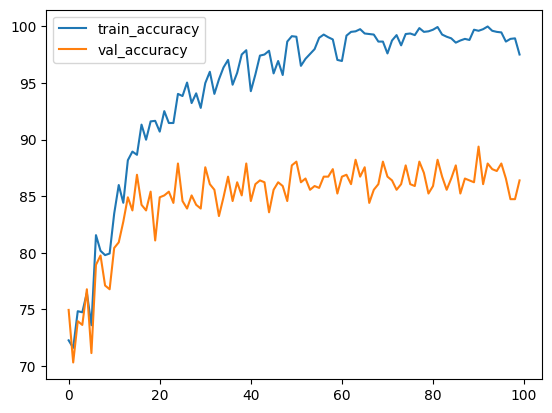

In [31]:
training_accuracy =  torch.tensor(trainingEpoch_accuracy, device = 'cpu').numpy()

validation_accuracy = torch.tensor(validationEpoch_accuracy, device = 'cpu').numpy()

plt.plot(training_accuracy, label='train_accuracy')
plt.plot(validation_accuracy,label='val_accuracy')
plt.legend()
plt.show

In [32]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


tensor(87.5421, device='cuda:0')
Test accuracy: 87.54%
